### Predicting Survival in the Titanic Data Set<br>
We will be using a decision tree to make predictions about the Titanic data
set from Kaggle. This data set provides information on the Titanic
passengers and can be used to predict whether a passenger survived or
not.

In [26]:
#Loading Data and modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from IPython.display import Image
import pydotplus
import graphviz


In [2]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pydotplus

Note: you may need to restart the kernel to use updated packages.


In [2]:
## Import warnings. 
import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.metrics import classification_report
Url = "https://raw.githubusercontent.com/BigDataGal/Python-for-Data-Science/master/titanic-train.csv"
titanic = pd.read_csv(Url)
titanic.columns = ['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','E mbarked']

You use only Pclass, Sex, Age, SibSp (Siblings aboard), Parch
(Parents/children aboard), and Fare to predict whether a passenger
survived.

In [4]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,E mbarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
col = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch','Fare']
X = titanic[col]
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,male,22.0,1,0,7.2500
1,1,female,38.0,1,0,71.2833
2,3,female,26.0,0,0,7.9250
3,1,female,35.0,1,0,53.1000
4,3,male,35.0,0,0,8.0500


In [7]:
y = titanic['Survived']

In [8]:
def missing_vals(df):
    mis_val=df.isnull().sum()
    mis_per=100*mis_val/len(df)
    mis_table=pd.concat([mis_val,mis_per],axis=1)
    mis_table=mis_table.rename(columns={0:'missing values',1:'missing percent'})
    mis_table=mis_table[mis_table.iloc[:,1] != 0].sort_values('missing percent',ascending=False).round(1)
    return mis_table

missing_vals(X).head()


,missing values,missing percent
Age,177,19.9


In [9]:
y.isnull().sum()

0

As we can see we have around 19.9 % missing data in Age column and no missing data in our target column

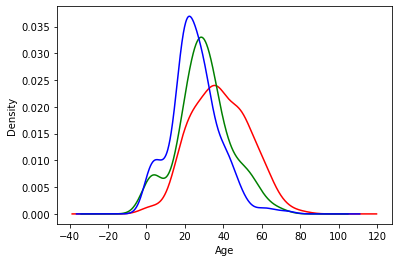

In [10]:
#Lets check distribution of age according to passenger class
X[X.Pclass == 1].Age.plot(kind = 'kde', color= 'r', label= '1st class')
X[X.Pclass == 2].Age.plot(kind = 'kde', color= 'g', label= '2nd class')
X[X.Pclass == 3].Age.plot(kind = 'kde', color= 'b', label= '3rd class')
plt.xlabel('Age')
plt.show()


as we can see mean age of different class passengers are different, so here we will fill nan values using mean for each class of passengers 

In [11]:
def fill_missing_age(dataset):
    for i in range(1,4):
        mean_age = dataset[dataset['Pclass']==i]['Age'].mean()
        dataset['Age'] = dataset['Age'].fillna(mean_age)
        return dataset

In [12]:
X = fill_missing_age(X)

In [13]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,male,22.0,1,0,7.2500
1,1,female,38.0,1,0,71.2833
2,3,female,26.0,0,0,7.9250
3,1,female,35.0,1,0,53.1000
4,3,male,35.0,0,0,8.0500


<AxesSubplot:xlabel='Survived', ylabel='Age'>

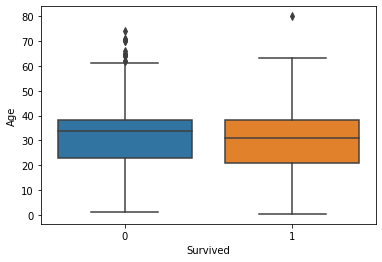

In [14]:
sns.boxplot(y, X['Age'])  # here 'y' is target variable

<AxesSubplot:xlabel='Survived', ylabel='Age'>

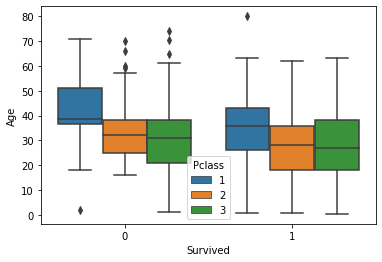

In [15]:
sns.boxplot(y, X['Age'], hue = X['Pclass'])

In [16]:
#lets convert Sex variable into binary feature
sex = {'female': 0, 'male' : 1}
X['Sex'] = X['Sex'].map(sex)

In [17]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  891 non-null    int64  
 1   Sex     891 non-null    int64  
 2   Age     891 non-null    float64
 3   SibSp   891 non-null    int64  
 4   Parch   891 non-null    int64  
 5   Fare    891 non-null    float64
dtypes: float64(2), int64(4)
memory usage: 41.9 KB


In [18]:
# Lets split our dataset into training and test set
X_train,X_test,y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 355)

In [19]:
#Lets train our dataset on descision tree classifier
clf = DecisionTreeClassifier()
clf.fit(X_train,y_train)

DecisionTreeClassifier()

In [20]:
clf.score(X_train,y_train)

0.9873595505617978

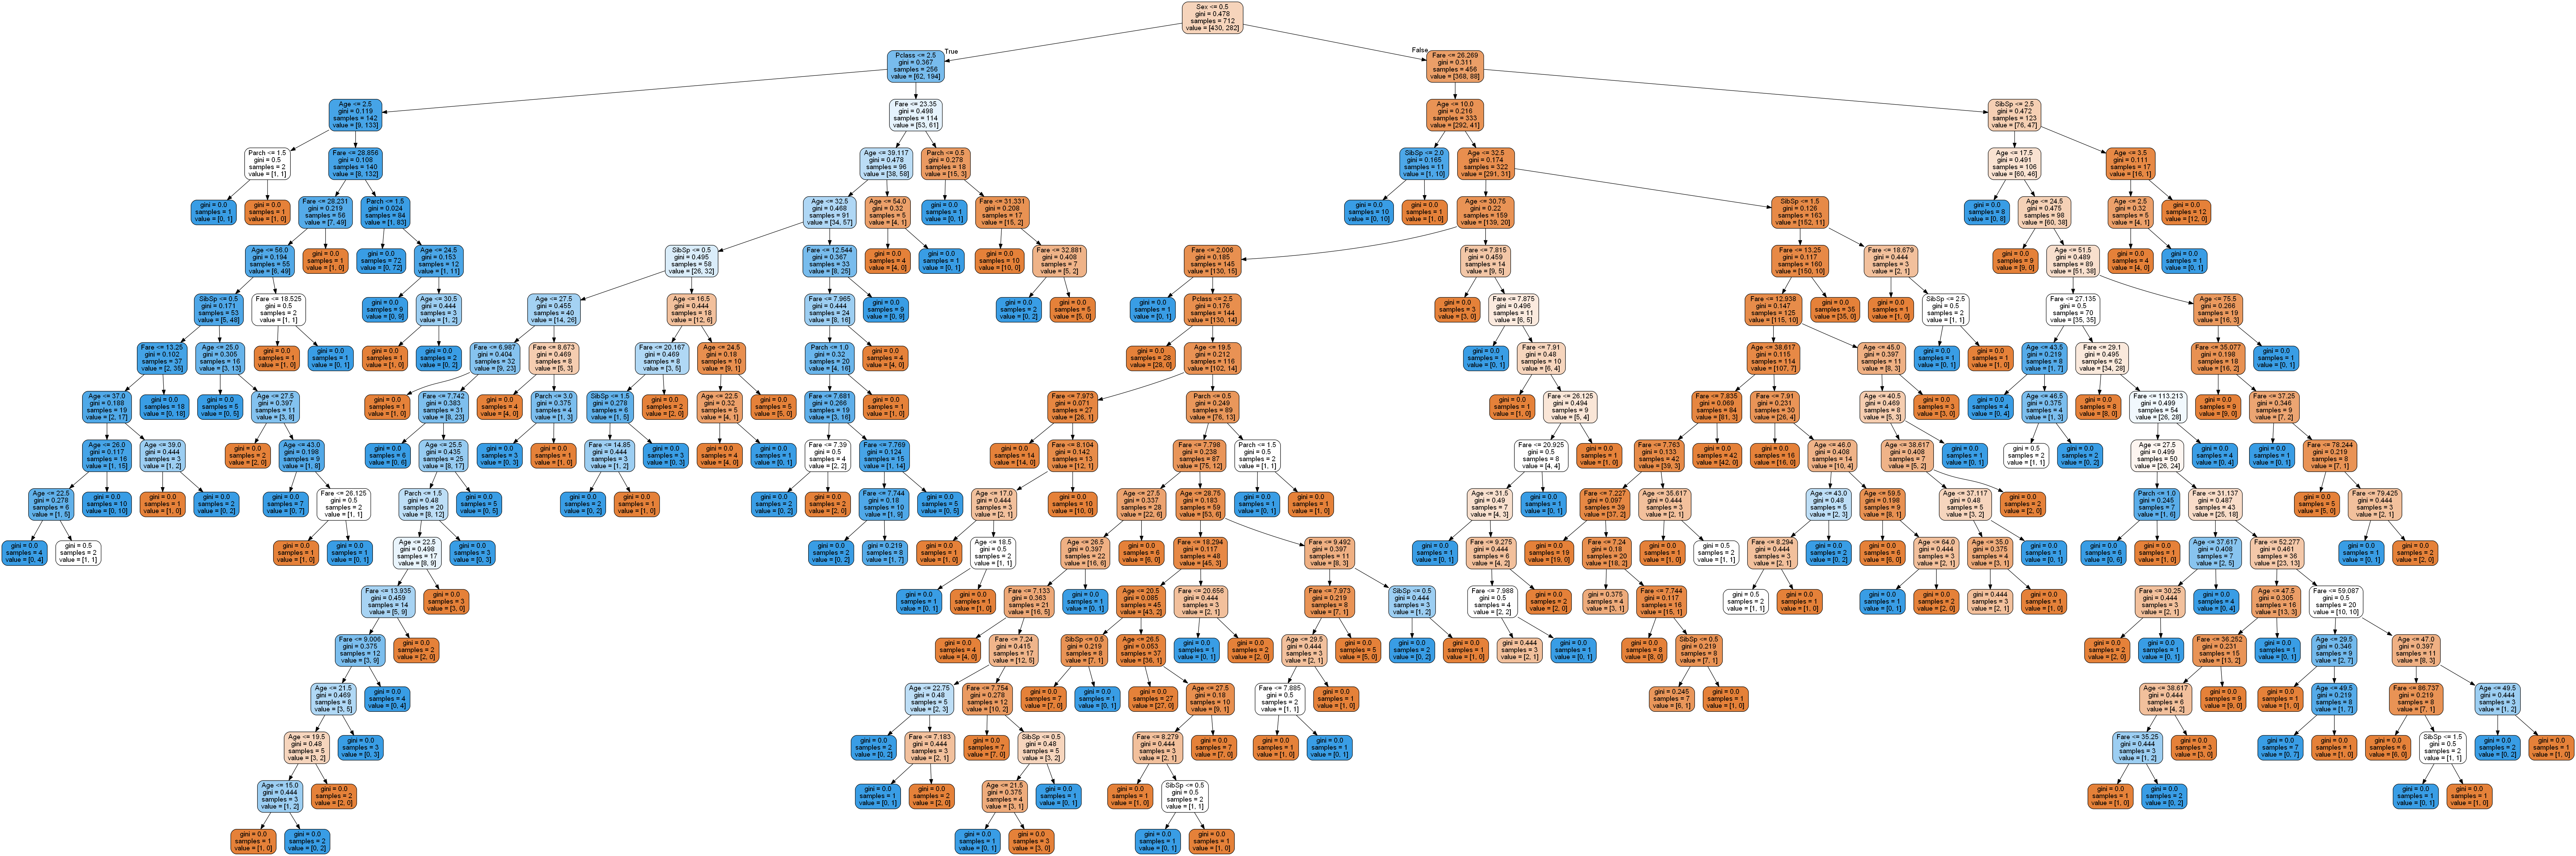

In [21]:
#Create a dot file to visualize the tree structure
dot_data = export_graphviz(clf, feature_names = X.columns.to_list(), rounded = True, filled = True)

# Draw Graph
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('mytree.png')
Image(graph.create_png())

In [101]:
X.columns.to_list()

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']

In [22]:
pred = clf.predict(X_test)

In [24]:
clf.score(X_test,y_test)

0.7262569832402235

let's do some hypertuning with our trained model and check whether we improve our model peformance

In [27]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [30]:
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y, test_size = 0.2, random_state = 355)

In [31]:
# Now let's see how well our model perform on scaled data
clf = DecisionTreeClassifier()
clf.fit(X_train,y_train)

DecisionTreeClassifier()

In [32]:
pred = clf.predict(X_test)

In [50]:
clf.score(X_test, y_test)

0.7318435754189944

Here we get .a little accuracy in test data. Let'n now try some hyperparameter tuning using GridSearchCV algorithm.


In [54]:
grid_param = {'criterion': ['gini','entropy'], 
              'max_depth': range(2,30,1),
              'min_samples_leaf': range(1,10,1),
              'min_samples_split': range(2,10,1),
              'splitter': ['best','random']
             }

In [55]:
grid_search = GridSearchCV(estimator = clf, param_grid = grid_param, cv = 5, n_jobs = -1 )

In [56]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(2, 30),
                         'min_samples_leaf': range(1, 10),
                         'min_samples_split': range(2, 10),
                         'splitter': ['best', 'random']})

In [57]:
best_parameters = grid_search.best_params_
print(best_parameters)

{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 9, 'splitter': 'random'}


In [58]:
grid_search.best_score_

0.8286319314488327

In [60]:
clf = DecisionTreeClassifier(criterion ='gini', max_depth= 10, min_samples_leaf = 3, 
                             min_samples_split = 9, splitter = 'random')
clf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=3, min_samples_split=9,
                       splitter='random')

In [61]:
clf.score(X_test,y_test)

0.8044692737430168

Great!! our test score has improved too much after selecting best parameters.Now our model is ready for deployment but first save into your system.

In [63]:
import pickle
with open(r'C:\Users\SHAKEB\Ineuron Assignments\Decision tree'+ '\model_prediction.sav', 'wb') as f:
    pickle.dump(clf, f)